In [24]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from tensorflow.keras import Sequential
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense
from keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.optimizers import SGD,Adam

In [2]:
train = pd.read_json('statoil-iceberg-classifier-challenge/data_train/processed/train.json')
test = pd.read_json('statoil-iceberg-classifier-challenge/data_test/processed/test.json')


In [3]:
import numpy as np
def get_scaled_imgs(df):
    imgs = []
    label =[]

    for i, row in df.iterrows():
        #make 75x75 image
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 + band_2 # plus since log(x*y) = log(x) + log(y)

        # Rescale
        a = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        b = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
        c = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())
        imgs.append(np.dstack((a, b, c)))
    return np.array(imgs)

In [4]:
data=get_scaled_imgs(train)
target = np.array(train['is_iceberg'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


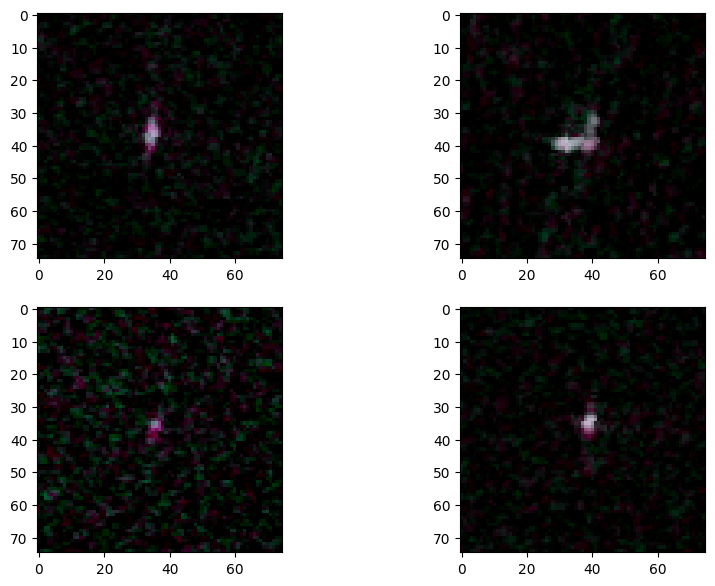

In [5]:
# create figure
fig = plt.figure(figsize=(10, 7))
rows = 2
columns = 2

for i in range(4):
# Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(data[i])

In [6]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data,target,test_size=0.2,random_state=1)

In [7]:
model=Sequential()

    # CNN 1
model.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Dropout(0.2))

    # CNN 2
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

    # CNN 3
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

    # CNN 4
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

    # You must flatten the data for the dense layers
model.add(Flatten())

    # Dense 1
model.add(Dense(512, activation='relu',input_shape=(257,)))
model.add(Dropout(0.2))

    # Dense 2
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

    # Output
model.add(Dense(1, activation="sigmoid"))

# Final model
optimizer = Adam(lr=1e-4)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 36, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 36, 36, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 17, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 17, 17, 128)       0

In [17]:
import keras
file_path = "weights_best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(file_path, monitor="val_accuracy", save_best_only=True, mode='max')
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.9, patience=10, min_lr=1e-6, mode="max", verbose=True)
early_stopping = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10, mode="max", verbose=True)
callbacks_list = [checkpoint, reduce_lr, early_stopping]

In [15]:
history=model.fit(x_train,y_train,batch_size=10,epochs=100,verbose=1,validation_split=0.2,callbacks=callbacks_list)

Epoch 1/100
103/103 [==============================] - 15s 133ms/step - loss: 0.0476 - accuracy: 0.9786 - val_loss: 0.5745 - val_accuracy: 0.8833 - lr: 9.0000e-04
Epoch 2/100
103/103 [==============================] - 16s 158ms/step - loss: 0.0526 - accuracy: 0.9805 - val_loss: 0.7503 - val_accuracy: 0.8638 - lr: 9.0000e-04
Epoch 3/100
103/103 [==============================] - 15s 142ms/step - loss: 0.0571 - accuracy: 0.9815 - val_loss: 0.5903 - val_accuracy: 0.8755 - lr: 9.0000e-04
Epoch 4/100
103/103 [==============================] - 15s 142ms/step - loss: 0.0545 - accuracy: 0.9815 - val_loss: 0.5494 - val_accuracy: 0.8716 - lr: 9.0000e-04
Epoch 5/100
103/103 [==============================] - 15s 148ms/step - loss: 0.0543 - accuracy: 0.9786 - val_loss: 0.5112 - val_accuracy: 0.8638 - lr: 9.0000e-04
Epoch 6/100
103/103 [==============================] - 15s 147ms/step - loss: 0.0662 - accuracy: 0.9776 - val_loss: 0.3853 - val_accuracy: 0.8755 - lr: 9.0000e-04
Epoch 7/100
103/103 [=

In [18]:
file_path = "./weights_best.hdf5"
model = keras.models.load_model(file_path)

In [19]:
score=model.evaluate(x_test,y_test,verbose=0)
print("Test Loss:",score[0])
print("accuracy:",score[1])

Test Loss: 0.4910922944545746
accuracy: 0.8753893971443176


In [20]:
predicted=model.predict(x_test)

11/11 [==============================] - 1s 62ms/step


In [21]:
test_data=get_scaled_imgs(test)
predicted=model.predict(test_data)

264/264 [==============================] - 20s 75ms/step


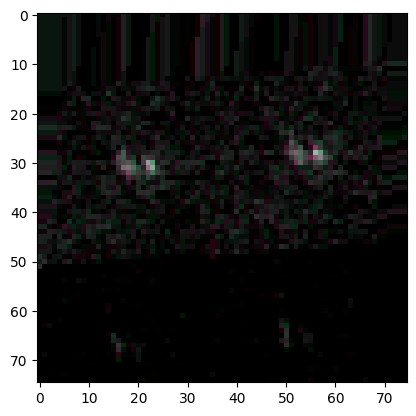

In [22]:
test_data.shape
plt.imshow(test_data[53])

In [23]:
model.save('icebergdetection_CNN.h5')

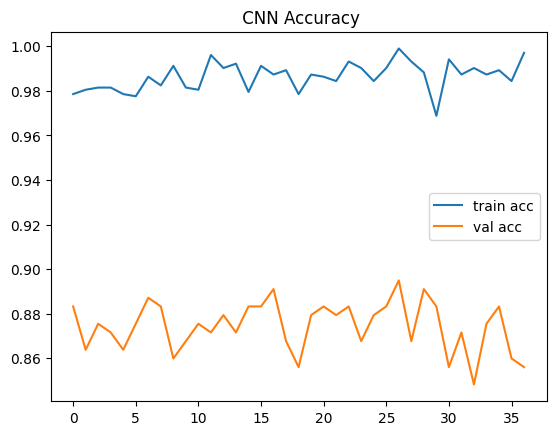

In [38]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title(" CNN Accuracy")
plt.legend()
plt.show()

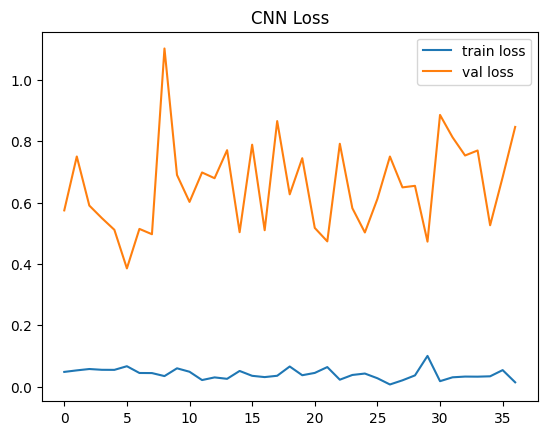

In [39]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title("CNN Loss")
plt.legend()
plt.show()

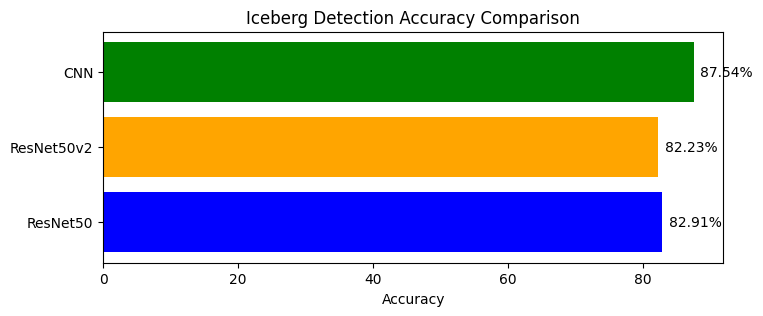

In [43]:
import matplotlib.pyplot as plt

model_names = ['ResNet50', 'ResNet50v2', 'CNN']
Resnet_50_Accuracy = 82.90908932685852
Resnet_50_V2_Accuracy = 82.23376870155334
Cnn_Accuracy = 87.53893971443176
accuracies = [Resnet_50_Accuracy, Resnet_50_V2_Accuracy, Cnn_Accuracy]

fig, ax = plt.subplots(figsize=(8,3))
bars = ax.barh(model_names, accuracies, color=['blue', 'orange', 'green'])

ax.set_xlabel('Accuracy')
ax.set_title('Iceberg Detection Accuracy Comparison')

for i, bar in enumerate(bars):
    ax.text(bar.get_width() + 1, i, f"{bar.get_width():.2f}%", ha='left', va='center')

plt.show()
